<a href="https://colab.research.google.com/github/SanjitaPrajapati/AI4CCEE_Fall_2024/blob/main/mini_project/MiniProject_1/Submission/sanjita_miniproject_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation and Visualization

In [2]:
#Install Dependencies
!pip install osmnx geopandas requests
!pip install pandas geopandas numpy
!pip install geopandas numpy matplotlib seaborn pysal
!pip install descartes
!pip install contextily


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.10/dist-packages/osmnx/_overpass.py:254: UserWarning: This area is 63 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


<Axes: >

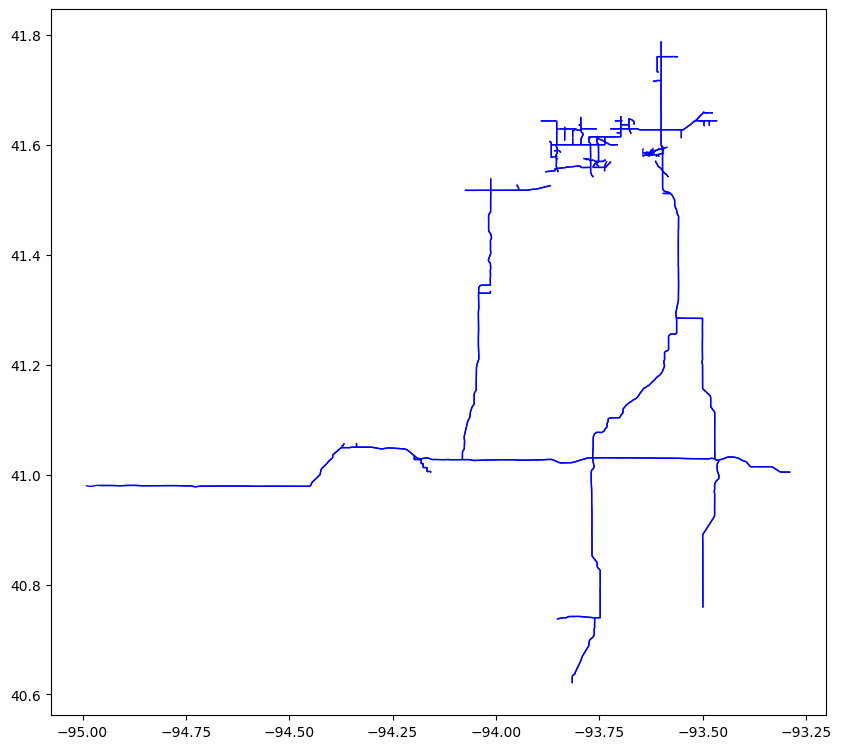

In [11]:
import osmnx as ox
import geopandas as gpd

# Set up your area of interest (Iowa)
place_name = "Iowa, USA"

# Define the custom Overpass query to filter arterial roads (primary and secondary) with lanes >= 2
custom_filter = ('["highway"~"primary|secondary|tertiary"]["lanes"~"[2-9]"]')

# Retrieve the road network
# Retrieve the road network
G = ox.graph_from_place(place_name, network_type='all', custom_filter=custom_filter)

# Convert the graph to a GeoDataFrame
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Optional: Save the multilane arterial roads to a file (e.g., GeoJSON or Shapefile)
gdf_edges.to_file("iowa_multilane_arterial_roads.geojson", driver="GeoJSON")

# Plot the multilane arterial roads
gdf_edges.plot(figsize=(10, 10), linewidth=1, edgecolor='blue')

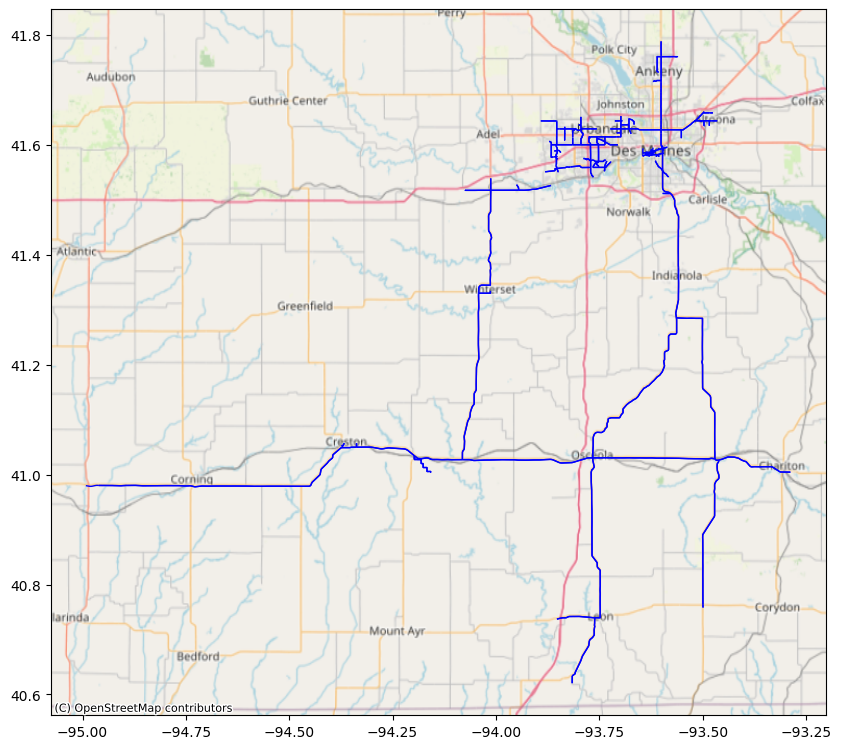

In [13]:
import contextily as ctx

# Plot the multilane arterial roads
ax = gdf_edges.plot(figsize=(10, 10), linewidth=1, edgecolor='blue')

# Add a basemap using contextily
ctx.add_basemap(ax, crs=gdf_edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Display the plot
plt.show()

## Hotspot and Data Visualization


In [62]:
import geopandas as gpd
from shapely.geometry import Point

# Load pedestrian fatalities data
df_pedestrian_fatalities = pd.read_csv("/content/combined_output.csv")

# Convert latitude/longitude into a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_pedestrian_fatalities['LONGITUD'], df_pedestrian_fatalities['LATITUDE'])]
gdf_pedestrian_fatalities = gpd.GeoDataFrame(df_pedestrian_fatalities, geometry=geometry)

# Set the coordinate system (assuming WGS84)
gdf_pedestrian_fatalities.crs = {'init': 'epsg:4326'}

<ipython-input-62-0600b2fd6fda>:5: DtypeWarning: Columns (15,28,84,86,88,90,92,94,118,120,126,152,166,168,170,197,214,216,219,221,223) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pedestrian_fatalities = pd.read_csv("/content/combined_output.csv")
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [64]:
print(gdf_pedestrian_fatalities['LONGITUD'])


0        -87.007094
1        -86.786853
2        -86.145281
3        -86.145281
4        -86.145281
            ...    
228297   -82.304575
228298   -82.304575
228299   -83.649892
228300   -83.649892
228301          NaN
Name: LONGITUD, Length: 228302, dtype: float64


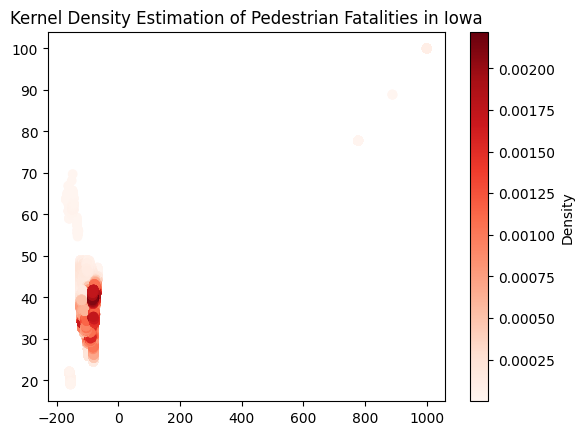

In [65]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
gdf_pedestrian_fatalities = gdf_pedestrian_fatalities.dropna(subset=['LONGITUD', 'LATITUDE'])
# Extract coordinates
coords = np.vstack([gdf_pedestrian_fatalities.geometry.x, gdf_pedestrian_fatalities.geometry.y])

# Apply KDE
kde = gaussian_kde(coords)
density = kde(coords)
gdf_pedestrian_fatalities['density'] = density
# Plot KDE results
plt.scatter(gdf_pedestrian_fatalities.geometry.x, gdf_pedestrian_fatalities.geometry.y, c=density, cmap='Reds')
plt.colorbar(label='Density')
plt.title("Kernel Density Estimation of Pedestrian Fatalities in Iowa")
plt.show()

gdf_pedestrian_fatalities.to_csv('pedestrian_fatalities.csv', index=False)


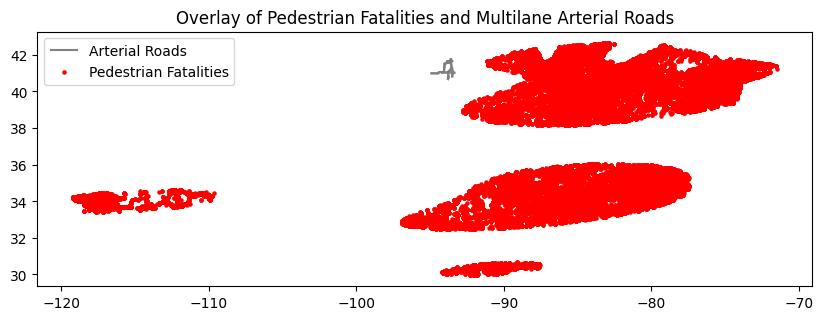

In [71]:
# Load multilane arterial roads
arterial_roads = gpd.read_file("/content/iowa_multilane_arterial_roads.geojson")

hotspots = gdf_pedestrian_fatalities[gdf_pedestrian_fatalities['density'] > 0.0015]
# Plot arterial roads and hotspots
fig, ax = plt.subplots(figsize=(10, 8))
arterial_roads.plot(ax=ax, color='gray', label='Arterial Roads')
hotspots.plot(ax=ax, color='red', markersize=5, label='Pedestrian Fatalities')
plt.legend()
plt.title("Overlay of Pedestrian Fatalities and Multilane Arterial Roads")
plt.show()


hotspots.to_csv('hotspots.csv', index=False)

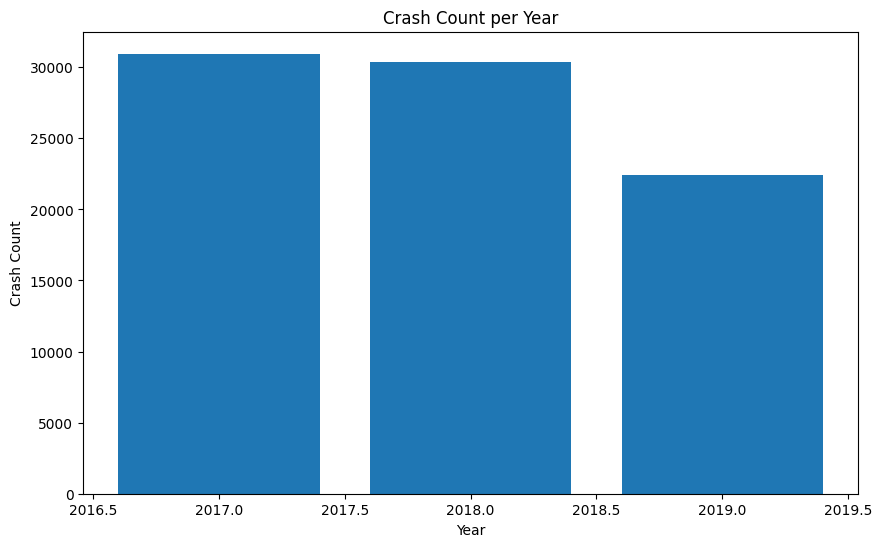

In [75]:

crash_counts_by_year = hotspots.groupby('YEAR')['YEAR'].count()

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(crash_counts_by_year.index, crash_counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Crash Count')
plt.title('Crash Count per Year')
plt.show()

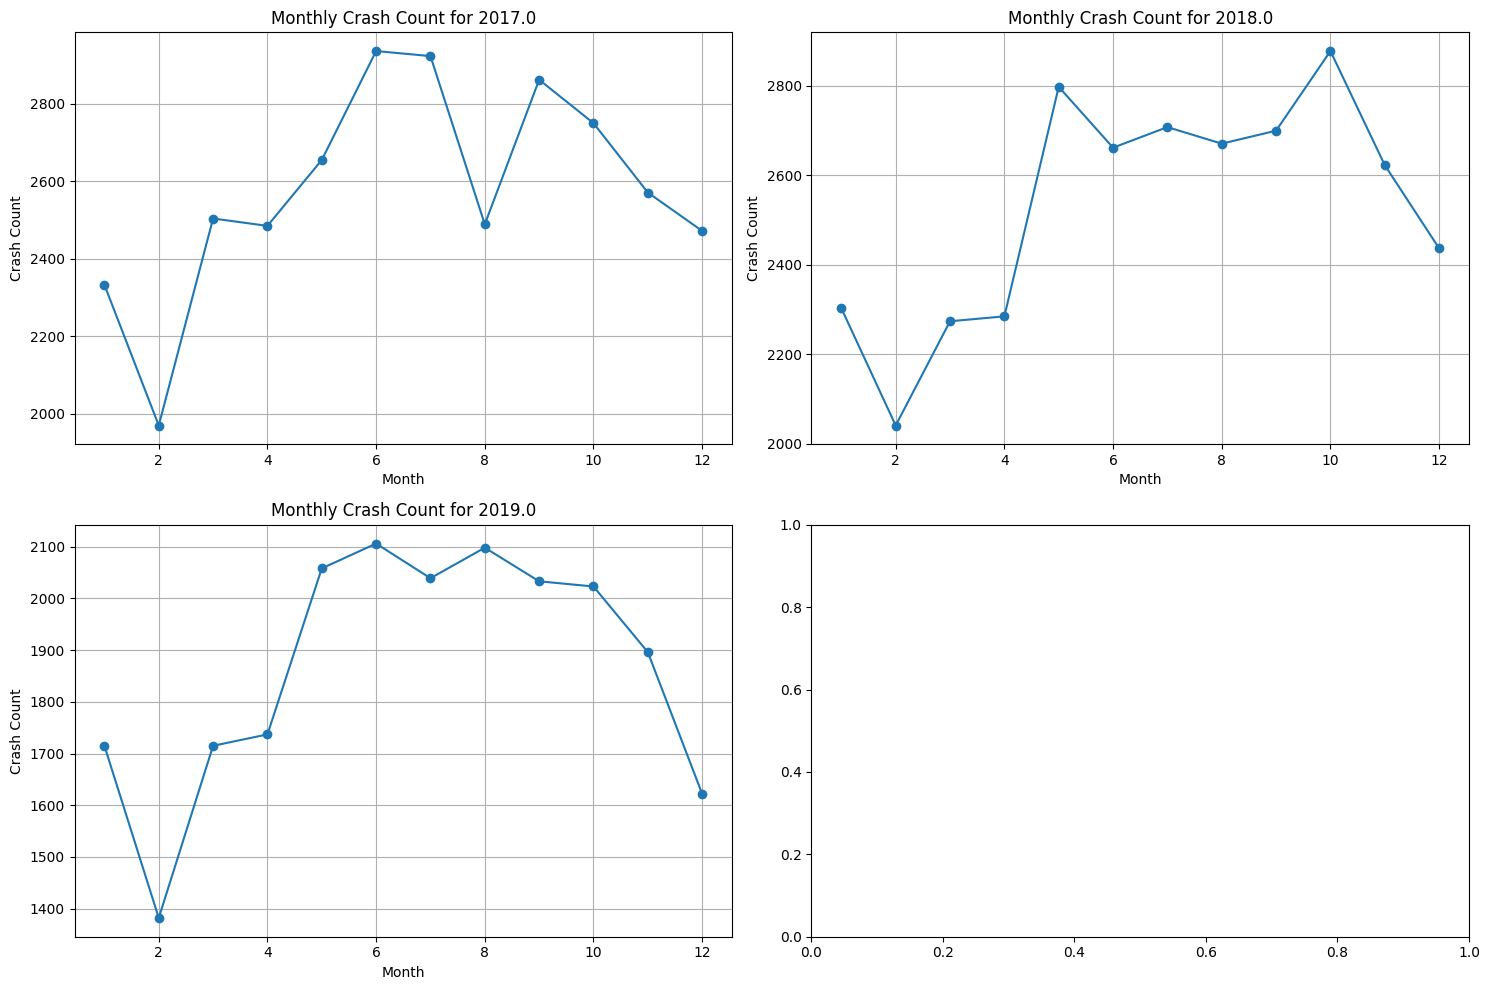

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by year and month and count the crashes
monthly_crash_counts = hotspots.groupby(['YEAR', 'MONTH_y'])['YEAR'].count().reset_index(name='Crash Count')

# Create a subplot for each year
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
years = monthly_crash_counts['YEAR'].unique()

for i, year in enumerate(years):
  row = i // 2
  col = i % 2
  ax = axes[row, col]

  year_data = monthly_crash_counts[monthly_crash_counts['YEAR'] == year]
  ax.plot(year_data['MONTH_y'], year_data['Crash Count'], marker='o')
  ax.set_xlabel('Month')
  ax.set_ylabel('Crash Count')
  ax.set_title(f'Monthly Crash Count for {year}')
  ax.grid(True)

plt.tight_layout()
plt.show()

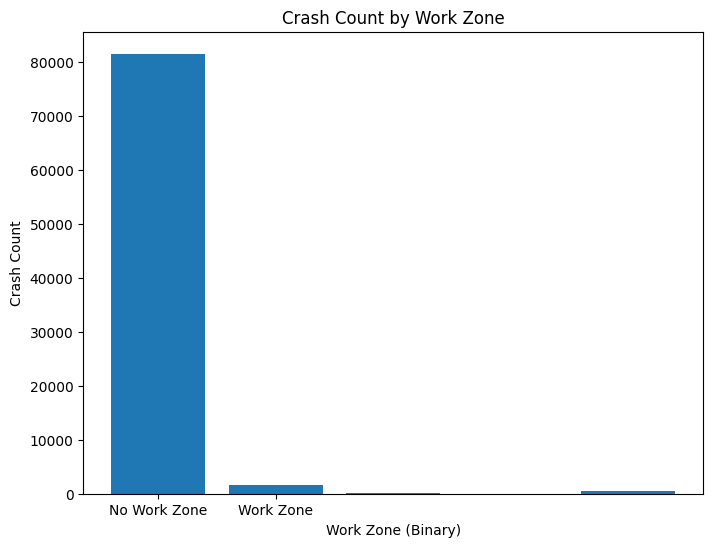

In [81]:
# Group by work zone and count crashes
crash_counts_by_work_zone = hotspots.groupby('WRK_ZONE')['WRK_ZONE'].count()

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(crash_counts_by_work_zone.index, crash_counts_by_work_zone.values)
plt.xlabel('Work Zone (Binary)')
plt.ylabel('Crash Count')
plt.title('Crash Count by Work Zone')
plt.xticks([0, 1], ['No Work Zone', 'Work Zone'])  # Set x-axis labels for binary values
plt.show()

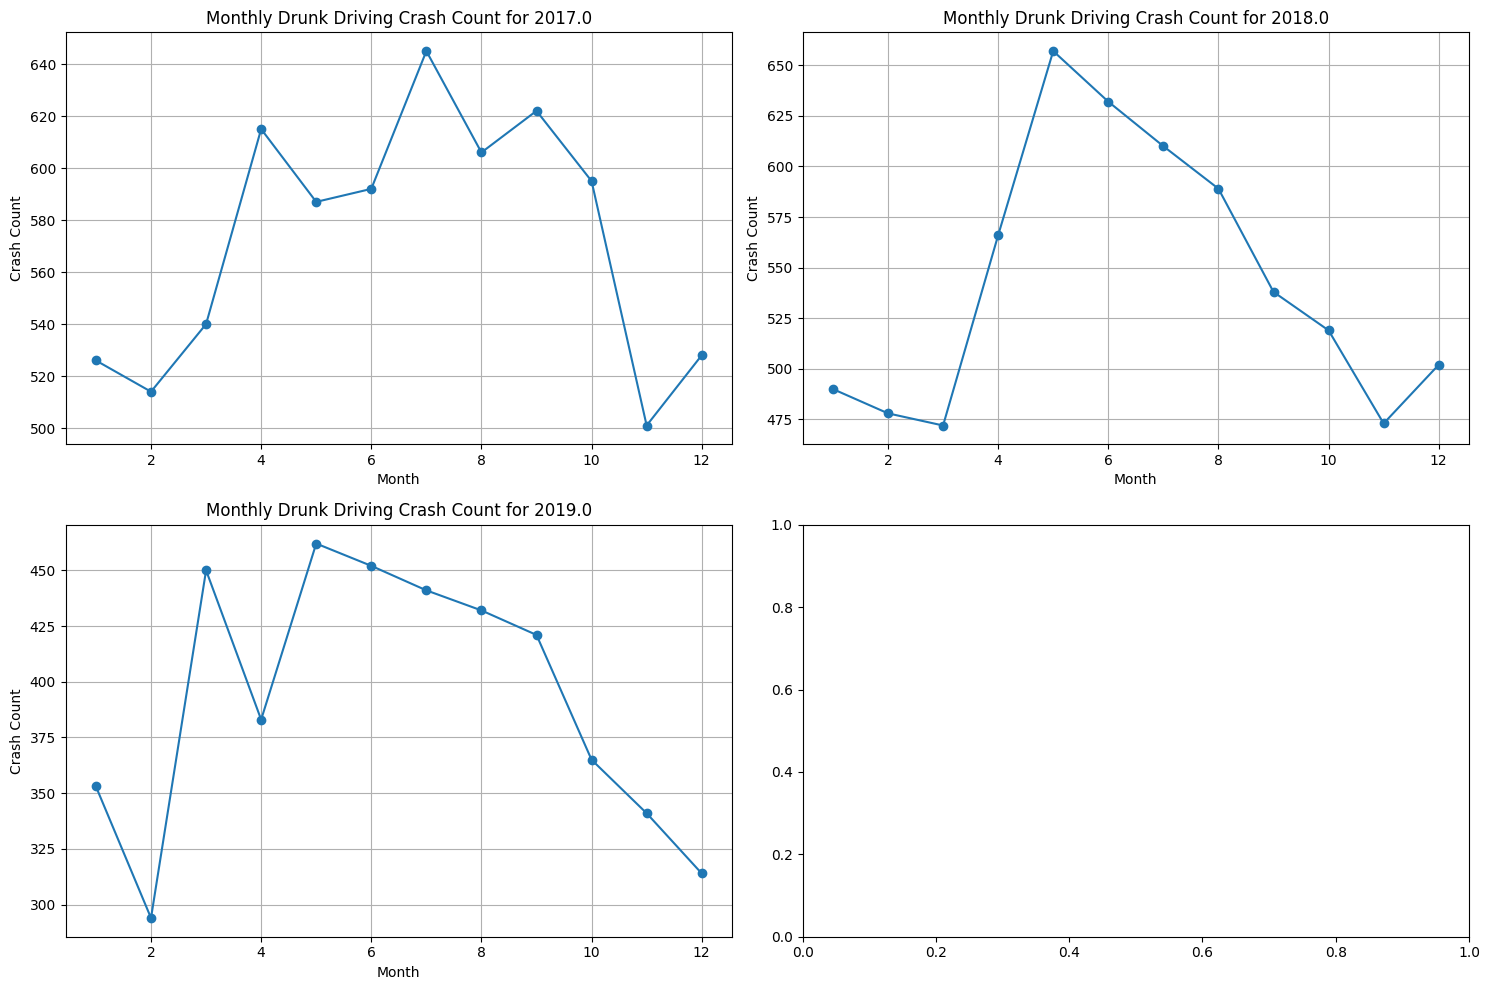

In [82]:
# Filter for crashes where the driver was drunk
drunk_driving_crashes = hotspots[hotspots['DRUNK_DR'] == 1]

# Group by year and month and count the crashes
monthly_drunk_driving_counts = drunk_driving_crashes.groupby(['YEAR', 'MONTH_y'])['YEAR'].count().reset_index(name='Crash Count')

# Create a subplot for each year
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
years = monthly_drunk_driving_counts['YEAR'].unique()

for i, year in enumerate(years):
  row = i // 2
  col = i % 2
  ax = axes[row, col]

  year_data = monthly_drunk_driving_counts[monthly_drunk_driving_counts['YEAR'] == year]
  ax.plot(year_data['MONTH_y'], year_data['Crash Count'], marker='o')
  ax.set_xlabel('Month')
  ax.set_ylabel('Crash Count')
  ax.set_title(f'Monthly Drunk Driving Crash Count for {year}')
  ax.grid(True)

plt.tight_layout()
plt.show()

## Model Training and Evaluation

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

In [53]:
crash_data = pd.read_csv("/content/combined_output.csv")
crash_data = crash_data.dropna(subset=['FATALS', 'DRUNK_DR'])
print(crash_data['FATALS'])

<ipython-input-53-1cce2a3f37cb>:1: DtypeWarning: Columns (15,28,84,86,88,90,92,94,118,120,126,152,166,168,170,197,214,216,219,221,223) have mixed types. Specify dtype option on import or set low_memory=False.
  crash_data = pd.read_csv("/content/combined_output.csv")


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
228296    1.0
228297    1.0
228298    1.0
228299    1.0
228300    1.0
Name: FATALS, Length: 228301, dtype: float64


In [54]:
features = crash_data[['VEH_NO','PER_NO','WEATHER1','LGT_COND','WRK_ZONE','ROUTE','FUNC_SYS_y','RUR_URB_y','HOUR_y','YEAR','MONTH_y','DAY_y','COUNTY_y','DRUNK_DR']]
target = crash_data['FATALS']
# Assuming your target variable is 'target_column' and other columns are features
X = features  # Replace 'target_column' with your target variable
y = target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [55]:
# Evaluate the model (e.g., using mean squared error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display feature importance scores
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df)

Mean Squared Error: 0.1636146772915389
       Feature  Importance
12    COUNTY_y    0.209588
11       DAY_y    0.164390
10     MONTH_y    0.137030
8       HOUR_y    0.124216
6   FUNC_SYS_y    0.061550
5        ROUTE    0.047574
9         YEAR    0.046853
1       PER_NO    0.046235
0       VEH_NO    0.041425
2     WEATHER1    0.039391
3     LGT_COND    0.033106
13    DRUNK_DR    0.023576
7    RUR_URB_y    0.016278
4     WRK_ZONE    0.008786
